### Info

Script to plot ECMWF synoptic charts.

Main script written by Matthias Schindler, LMU

Adapted by Stephan Rasp, LMU

Adapted by Tobias Necker, UNIVIE


In [1]:
!module list

Currently Loaded Modulefiles:
 1) enstools/v2021.11  
>

In [2]:
%matplotlib inline 

import sys, os, copy, scipy, math, getpass, subprocess, argparse, time, re, pdb, socket
import xarray as xr
import numpy as np
import pandas as pd
import datetime as dt

# Loading Data Modules
from enstools.io import read, write
from enstools.plot import contour
import pygrib

# Plotting Modules
import matplotlib
from matplotlib import pyplot as plt
import cartopy
import cartopy.crs as crs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colors as mcolors
import numpy as np
import datetime
import math as m
from scipy.ndimage.filters import gaussian_filter
import sys
from subprocess import check_output



/tmp/ipykernel_492408/1645070356.py:28: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [3]:
font = {'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)

In [4]:
### returns grib data, given a prescribed absolute path and a 'field' 
def grbdat(path, field):
    grib_load   = path
    grib_file   = pygrib.open(grib_load)
    grib        = grib_file.select(name=field)[0]
    data        = grib.values
    grib_file.close()
    return data  

### returns lat, lon
def get_latlon(path):
    grib_load   = path
    grib_file   = pygrib.open(grib_load)
    grib        = grib_file.select()[0]
    lat, lon    = grib.latlons()
    return lat, lon

## DATA INFO

Geopotential	z	m2 s-2	ID=129

Temperature	T	K	ID=130

U component of wind	u	m s-1	ID=131

V component of wind	v	m s-1	ID=132

Mean sea level pressure	msl	Pa	ID=151

Relative humidity	r	ID=157

Specific humidity   q   ID=133

Equivalentpotential temperature   EqiT = $\Biggl(T + \frac{L_v}{c_p}\frac{q}{1-q}\Biggr) \Biggl(\frac{p_0}{p}\Biggr)^{\frac{R_d}{c_p}}$   K

In [5]:
# Generally data from: 27.05 00:00 - 10.06 12:00
# Wind and q data from: 28.05 00:00 - 30.05 12:00

#insert date and time
day = '28'
month = '05'
time = '0000'

#convert for the plots
if month == '05':
    m = 'Mai'
elif month == '06':
    m = 'Juni'
if time == '0000':
    t = '00:00'
elif time == '1200':
    t = '12:00'

In [6]:
basedir = '/scratch/das/tnecker/ecmwf'
result_dir = '/scratch/das/tnecker/ecmwf/plots/'
exp_od = '0001'
tim='2016'+month+day
timelist = [tim]
utc=time
figtype = 'png'
plotdomain  = True

In [7]:
latlon = get_latlon(basedir + '/0001_20160529_0000UTC_an_0_129.128_1000.grib')
lat = latlon[0]
#print lat.shape
#inds = (0, lat.shape[0]/2, 0, -1)
### filter global data for northern hemisphere to save some memory...
#lat = lat[inds[0]:inds[1],inds[2]:inds[3]]      
lon = latlon[1]
#lon = lon[inds[0]:inds[1],inds[2]:inds[3]]
print (lat.shape)
print (lon.shape)

(901, 3600)
(901, 3600)


In [9]:
print ('reading data: analysis (Geopotential) -- ' + exp_od)
datadict_od_geopot_500      = [{} for i in range(len(tim))]
dirname     = basedir + '/'
filename    = exp_od + '_' + tim + '_' + utc +'UTC_an_0_129.128_500.grib'
path        = dirname + filename
data        = grbdat(path, 'Geopotential')
#data        = data[inds[0]:inds[1],inds[2]:inds[3]]
datadict_od_geopot_500[0].update({tim : data})
print (path)

print ('reading data: analysis (Mean sea level pressure) -- ' + exp_od)
datadict_od_slp              = [{} for i in range(len(tim))]
dirname     = basedir + '/'
filename    = exp_od + '_' + tim + '_' + utc +'UTC_an_0_151.128_sfc.grib'
path        = dirname + filename
data        = grbdat(path, 'Mean sea level pressure')
data        = gaussian_filter(data, 10)
#data        = gaussian_filter(data[inds[0]:inds[1],inds[2]:inds[3]], 10,
#                              mode='wrap')
datadict_od_slp[0].update({tim : data})
print (path)

print ('reading data: analysis (Temperature) -- ' + exp_od)
datadict_od_t_850              = [{} for i in range(len(tim))]
dirname     = basedir + '/'
filename    = exp_od + '_' + tim + '_' + utc +'UTC_an_0_130.129_850.grib'
path        = dirname + filename
data        = grbdat(path, 'Temperature')
data        = gaussian_filter(data, 12)
datadict_od_t_850[0].update({tim : data})
print (path)

print ('reading data: analysis (Temperature) -- ' + exp_od)
datadict_od_t_500              = [{} for i in range(len(tim))]
dirname     = basedir + '/'
filename    = exp_od + '_' + tim + '_' + utc +'UTC_an_0_130.129_500.grib'
path        = dirname + filename
data        = grbdat(path, 'Temperature')
data        = gaussian_filter(data, 12)
datadict_od_t_500[0].update({tim : data})
print (path)

print ('reading data: analysis (Relative humidity) -- ' + exp_od)
datadict_od_rh_850              = [{} for i in range(len(tim))]
dirname     = basedir + '/'
filename    = exp_od + '_' + tim + '_' + utc +'UTC_an_0_157.129_850.grib'
path        = dirname + filename
data        = grbdat(path, 'Relative humidity')
data        = gaussian_filter(data, 12, mode='wrap')
datadict_od_rh_850[0].update({tim : data})
print (path)

print ('reading data: analysis (Specific humidity) -- ' + exp_od)
datadict_od_qv_850              = [{} for i in range(len(tim))]
dirname     = basedir + '/'
filename    = exp_od + '_' + tim + '_' + utc +'UTC_an_0_133.128_850.grib'
path        = dirname + filename
data        = grbdat(path, 'Specific humidity')
data        = gaussian_filter(data, 12, mode='wrap')
datadict_od_qv_850[0].update({tim : data})
print (path)

print ('reading data: analysis (Geopotential) -- ' + exp_od)
datadict_od_geopot_1000      = [{} for i in range(len(tim))]
dirname     = basedir + '/'
filename    = exp_od + '_' + tim + '_' + utc +'UTC_an_0_129.128_1000.grib'
path        = dirname + filename
data        = grbdat(path, 'Geopotential')
#data        = data[inds[0]:inds[1],inds[2]:inds[3]]
datadict_od_geopot_1000[0].update({tim : data})
print (path)


print ('reading data: analysis (U component of wind) -- ' + exp_od)
datadict_od_u_300              = [{} for i in range(len(tim))]
dirname     = basedir + '/'
filename    = exp_od + '_' + tim + '_' + utc +'UTC_an_0_131.128_300.grib'
path        = dirname + filename
data        = grbdat(path, 'U component of wind')
#data        = gaussian_filter(data, 10, mode='wrap')
datadict_od_u_300[0].update({tim : data})
print (path)


print ('reading data: analysis (V component of wind) -- ' + exp_od)
datadict_od_v_300              = [{} for i in range(len(tim))]
dirname     = basedir + '/'
filename    = exp_od + '_' + tim + '_' + utc +'UTC_an_0_132.128_300.grib'
path        = dirname + filename
data        = grbdat(path, 'V component of wind')
#data        = gaussian_filter(data, 10, mode='wrap')
datadict_od_v_300[0].update({tim : data})
print (path)


reading data: analysis (Geopotential) -- 0001
/scratch/das/tnecker/ecmwf/0001_20160528_0000UTC_an_0_129.128_500.grib
reading data: analysis (Mean sea level pressure) -- 0001
/scratch/das/tnecker/ecmwf/0001_20160528_0000UTC_an_0_151.128_sfc.grib
reading data: analysis (Temperature) -- 0001
/scratch/das/tnecker/ecmwf/0001_20160528_0000UTC_an_0_130.129_850.grib
reading data: analysis (Temperature) -- 0001
/scratch/das/tnecker/ecmwf/0001_20160528_0000UTC_an_0_130.129_500.grib
reading data: analysis (Relative humidity) -- 0001
/scratch/das/tnecker/ecmwf/0001_20160528_0000UTC_an_0_157.129_850.grib
reading data: analysis (Specific humidity) -- 0001
/scratch/das/tnecker/ecmwf/0001_20160528_0000UTC_an_0_133.128_850.grib
reading data: analysis (U component of wind) -- 0001
/scratch/das/tnecker/ecmwf/0001_20160528_0000UTC_an_0_131.128_300.grib
reading data: analysis (V component of wind) -- 0001
/scratch/das/tnecker/ecmwf/0001_20160528_0000UTC_an_0_132.128_300.grib


## Plots

In [10]:
lat2d=np.load('/scratch/das/tnecker/kwork/experiments/lat2d_low_resolution.npy')
lon2d=np.load('/scratch/das/tnecker/kwork/experiments/lon2d_low_resolution.npy')
d1lat=np.load('/scratch/das/tnecker/kwork/experiments/lat2d_low_resolution.npy')
d1lon=np.load('/scratch/das/tnecker/kwork/experiments/lon2d_low_resolution.npy')
d2lat=np.load('/scratch/das/tnecker/kwork/experiments/lat2d_high_resolution.npy')
d2lon=np.load('/scratch/das/tnecker/kwork/experiments/lon2d_high_resolution.npy')

### Bodendruck

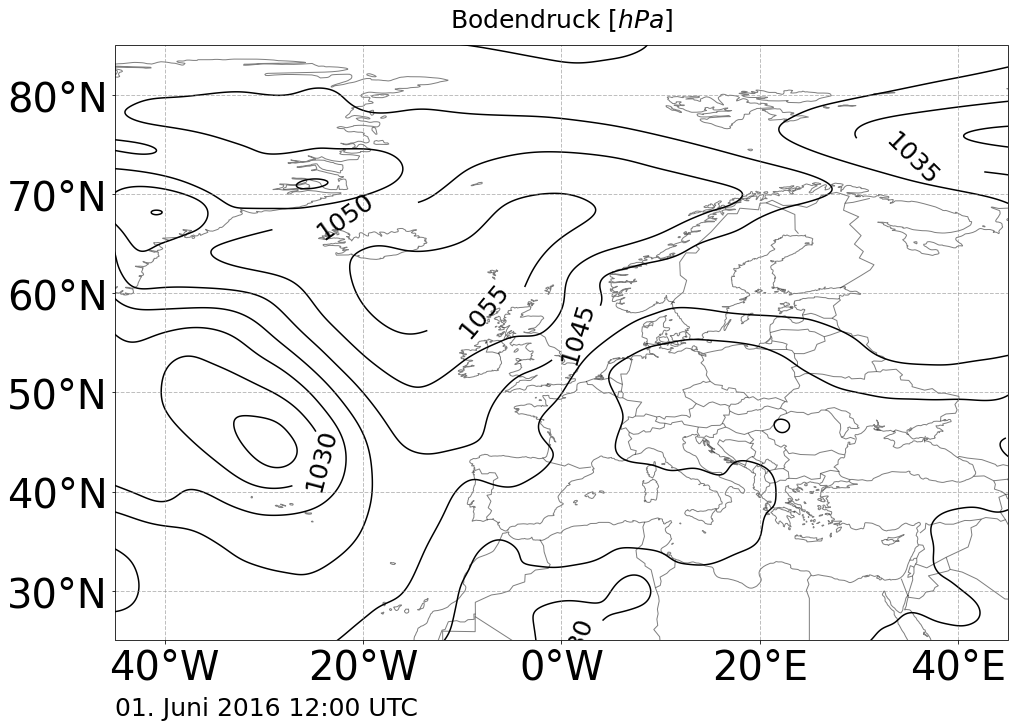

In [118]:
# Contourplot

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

cs1 = plt.contour(lon, lat, (datadict_od_slp[0][timelist[0]]/9.80665)/10., levels=np.arange(990,1060,5),colors='black', transform=crs.PlateCarree())

ax.clabel(cs1,np.arange(990,1060,5),fontsize=25,inline=True,inline_spacing=-11,manual=False,rightside_up=True)
ax.coastlines(resolution='50m',alpha = 0.5)
ax.add_feature(cfeature.BORDERS,alpha = 0.5)
ax.set_extent([-45,45,25,85], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[-40,-20,0, 20,40], crs=crs.PlateCarree())
ax.set_yticks(ticks=[30,40, 50, 60,70,80], crs=crs.PlateCarree())
ax.set_title('Bodendruck [$hPa$]', size =25,y=1.02)
ax.text(-45,17.5,day+'. '+m+' 2016 '+t+' UTC', size =25)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_ECMWF/new_Bodendruck_500_2016'+month+day+time+'.png')

In [ ]:
# Color Contourplot

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

cs1 = plt.contourf(lon, lat, (datadict_od_slp[0][timelist[0]]/9.80665)/10., 
                   cmap='inferno', extend='both', levels=np.arange(1020,1056,1), transform=crs.PlateCarree()) 
cb = plt.colorbar(cs1,ticks = np.linspace(1020,1055,8))
cb.ax.tick_params(labelsize=20)

ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([-35,45,25,85], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[-30,-20,-10,0, 10, 20,30,40], crs=crs.PlateCarree())
ax.set_yticks(ticks=[30,40, 50, 60,70,80], crs=crs.PlateCarree())
ax.set_title('Bodendruck [$hPa$]', size =25,y=1.02)
ax.text(-35,18,day+'. '+m+' 2016 '+t+' UTC', size =25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

#plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots/Bodendruck_2016'+month+day+time+'.png')

### Geopotential

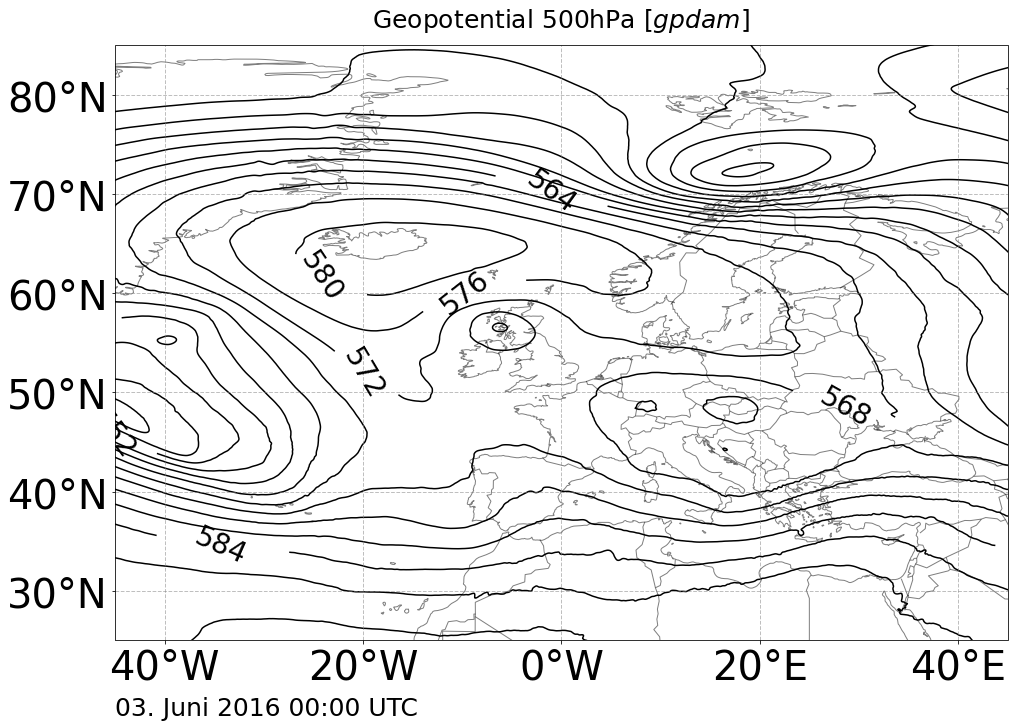

In [96]:
# Contourplot

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

cs1 = plt.contour(lon, lat, (datadict_od_geopot_500[0][timelist[0]]/9.80665)/10., levels=np.arange(528,596,4),colors='black', transform=crs.PlateCarree()) 

ax.clabel(cs1,np.arange(548,594,4),fontsize=28,inline=True,inline_spacing=-9,manual=False,rightside_up=True)
ax.coastlines(resolution='50m',alpha = 0.5)
ax.add_feature(cfeature.BORDERS,alpha = 0.5)
ax.set_extent([-45,45,25,85], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[-40,-20,0, 20,40], crs=crs.PlateCarree())
ax.set_yticks(ticks=[30,40, 50, 60,70,80], crs=crs.PlateCarree())
ax.set_title('Geopotential 500hPa [$gpdam$]', size =25,y=1.02)
ax.text(-45,17.5,day+'. '+m+' 2016 '+t+' UTC', size =25)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_ECMWF/new_Geopot_500_2016'+month+day+time+'.png')

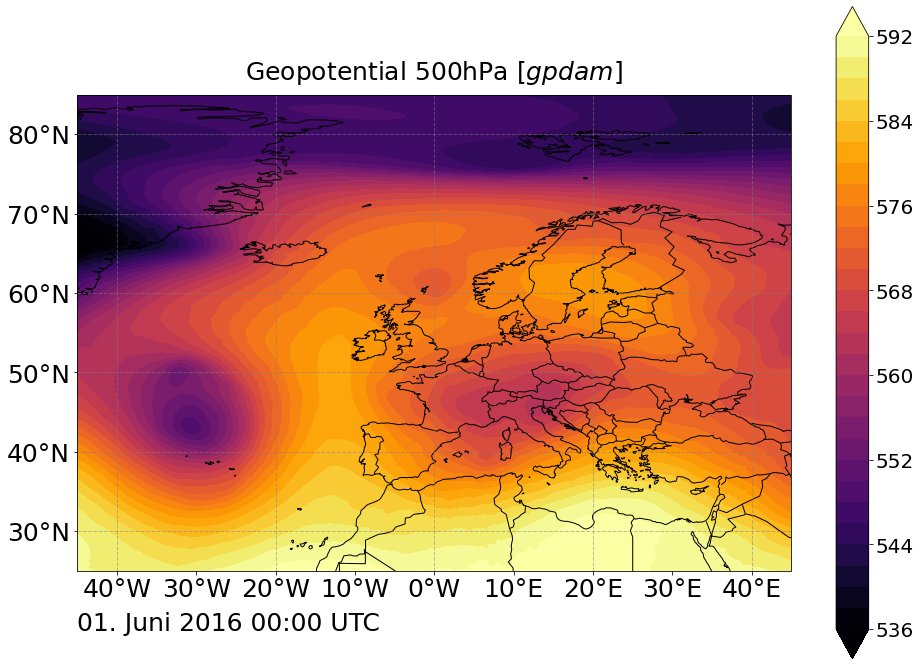

In [116]:
#Color Contourplot

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

cs1 = plt.contourf(lon, lat, (datadict_od_geopot_500[0][timelist[0]]/9.80665)/10., 
                   cmap='inferno', extend='both', levels=np.arange(536,594,2), transform=crs.PlateCarree()) 
cb = plt.colorbar(cs1,ticks = np.linspace(536,592,8))
cb.ax.tick_params(labelsize=20)

ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([-45,45,25,85], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[-40,-30,-20,-10,0, 10, 20,30,40], crs=crs.PlateCarree())
ax.set_yticks(ticks=[30,40, 50, 60,70,80], crs=crs.PlateCarree())
ax.set_title('Geopotential 500hPa [$gpdam$]', size =25,y=1.02)
ax.text(-45,17.5,day+'. '+m+' 2016 '+t+' UTC', size =25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

#plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots/Geopot_500_2016'+month+day+time+'.png')

### Wind

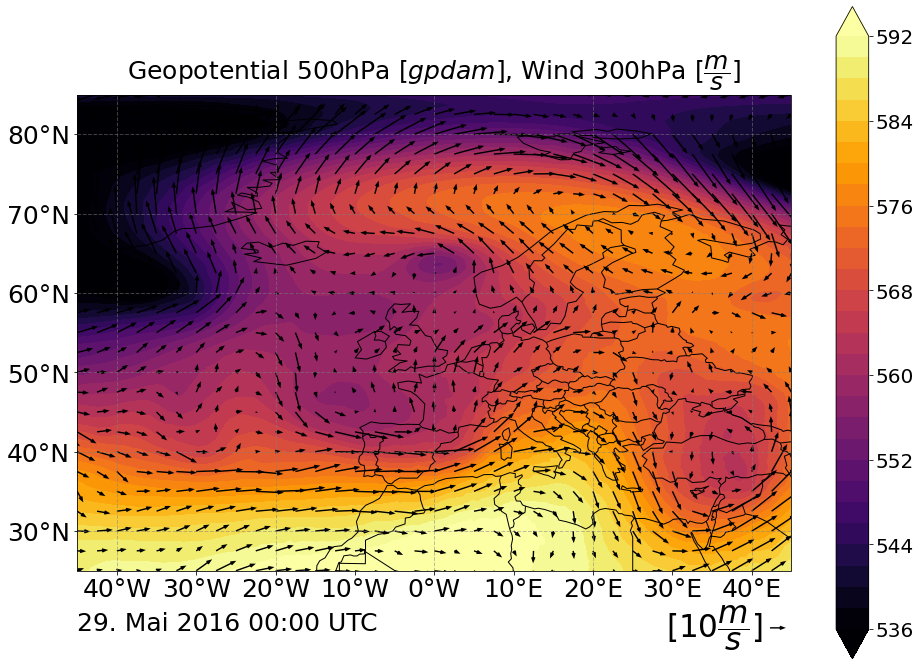

In [15]:
#Quiverplot

al = 25

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

cs1 = plt.contourf(lon, lat, (datadict_od_geopot_500[0][timelist[0]]/9.80665)/10., 
                   cmap='inferno', extend='both', levels=np.arange(536,594,2), transform=crs.PlateCarree()) 
cb = plt.colorbar(cs1,ticks = np.linspace(536,592,8))
cb.ax.tick_params(labelsize = 20)

Q = plt.quiver(lon[::al,::al], lat[::al,::al], datadict_od_u_300[0][timelist[0]][::al,::al], datadict_od_v_300[0][timelist[0]][::al,::al], transform=crs.PlateCarree(), width=0.002, headwidth=3 
               ,headlength=4, scale=1000)
qk = plt.quiverkey(Q, 0.97, -0.12, 22.22, '[10$\dfrac{m}{s}$]', labelpos='W',fontproperties={'size':'xx-large'})


ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([-45,45,25,85], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[-40,-30,-20,-10,0, 10, 20,30,40], crs=crs.PlateCarree())
ax.set_yticks(ticks=[30,40, 50, 60,70,80], crs=crs.PlateCarree())
ax.set_title('Geopotential 500hPa [$gpdam$], Wind 300hPa [$\dfrac{m}{s}$]', size =25,y=1.02)
ax.text(-45,17.5,day+'. '+m+' 2016 '+t+' UTC', size =25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

#plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots/Wind_300_Geopot_500_2016'+month+day+time+'.png')

### Divergenz

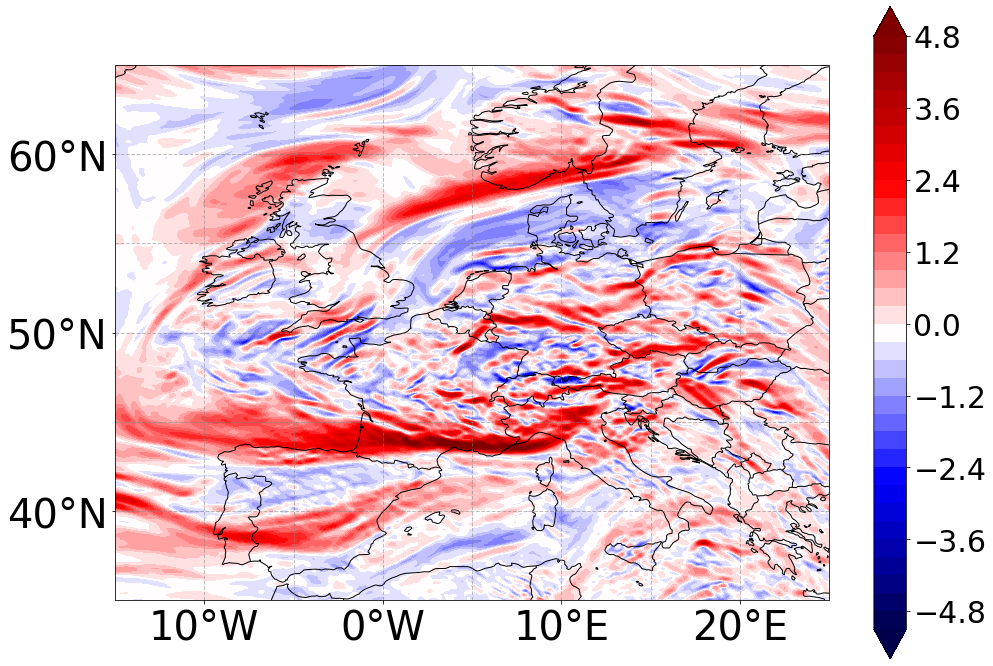

In [159]:
#Color Contourplot

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

cs1 = plt.contourf(lon, lat, np.add(np.gradient(datadict_od_u_300[0][timelist[0]],axis=0),np.gradient(datadict_od_v_300[0][timelist[0]],axis=0)), 
                   cmap='seismic', extend='both', levels=np.arange(-5.1,5.1,0.3), transform=crs.PlateCarree()) 
cb = plt.colorbar(cs1)
cb.ax.tick_params(labelsize = 30)

ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([-15,25,35,65], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[-10,0, 10,20], crs=crs.PlateCarree())
ax.set_yticks(ticks=[40, 50,60], crs=crs.PlateCarree())
# ax.set_title('Divergenz 300hPa [$s^{-1}$]', size = 25,y=1.02)
# ax.text(-15,31,day+'. '+m+' 2016 '+t+' UTC', size =25)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_ECMWF/new_Divergenz_300_2016'+month+day+time+'.png')

### Spezifische Feuchte

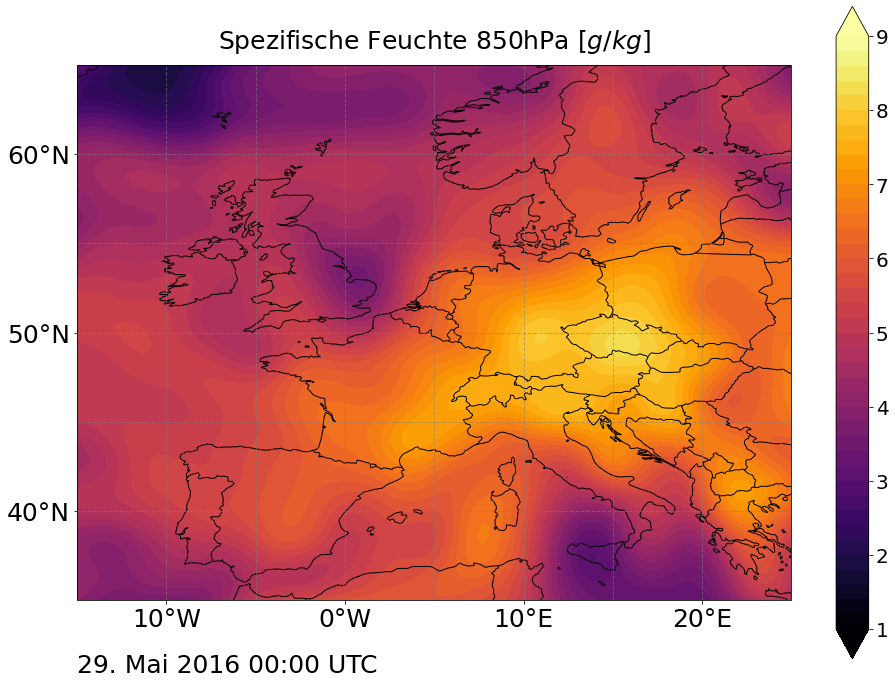

In [17]:
#Color Contourplot

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

cs1 = plt.contourf(lon, lat, (datadict_od_qv_850[0][timelist[0]])*1000, levels=np.arange(1,9.1,0.2), cmap='inferno', extend = 'both', transform=crs.PlateCarree()) 
cb = plt.colorbar(cs1)
cb.ax.tick_params(labelsize =20)

ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([-15,25,35,65], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[-10,0, 10,20], crs=crs.PlateCarree())
ax.set_yticks(ticks=[40, 50,60], crs=crs.PlateCarree())
ax.set_title('Spezifische Feuchte 850hPa [$g/kg$]', size = 25,y=1.02)
ax.text(-15,31,day+'. '+m+' 2016 '+t+' UTC', size =25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

#plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots/Spezifische_Feuchte_850_2016'+month+day+time+'.png')

### Relative Feuchte

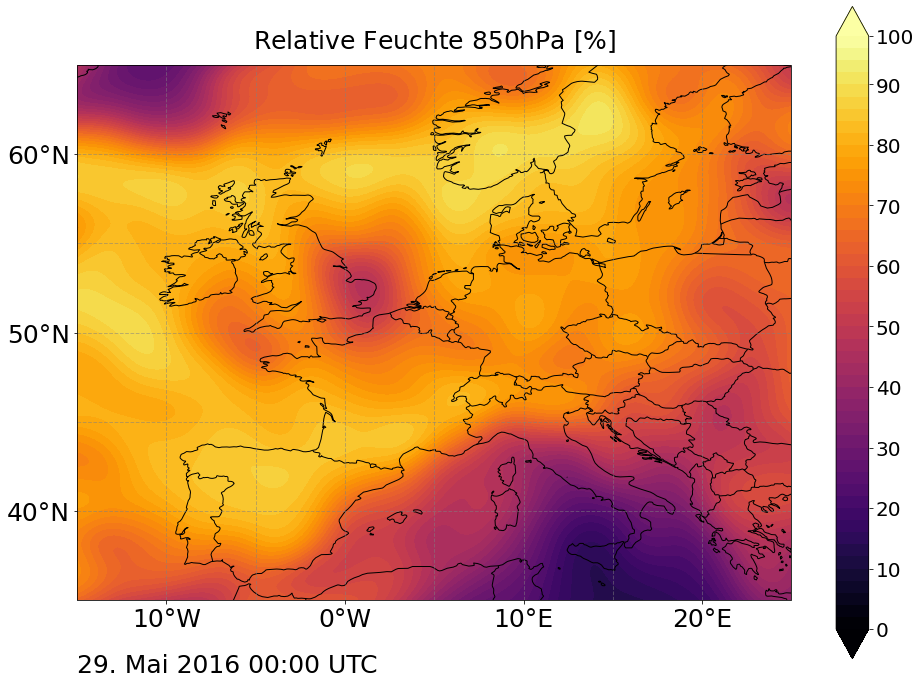

In [18]:
#Color Contourplot

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

cs1 = plt.contourf(lon, lat, (datadict_od_rh_850[0][timelist[0]]), levels=np.arange(0,100,2), cmap='inferno', extend = 'both', transform=crs.PlateCarree()) 
cb = plt.colorbar(cs1,ticks = np.linspace(0,100,11))
cb.ax.tick_params(labelsize =20)

ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([-15,25,35,65], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[-10,0, 10,20], crs=crs.PlateCarree())
ax.set_yticks(ticks=[40, 50,60], crs=crs.PlateCarree())
ax.set_title('Relative Feuchte 850hPa [$\%$]', size = 25,y=1.02)
ax.text(-15,31,day+'. '+m+' 2016 '+t+' UTC', size =25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

#plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots/Relative_Feuchte_850_2016'+month+day+time+'.png')

### Temperatur

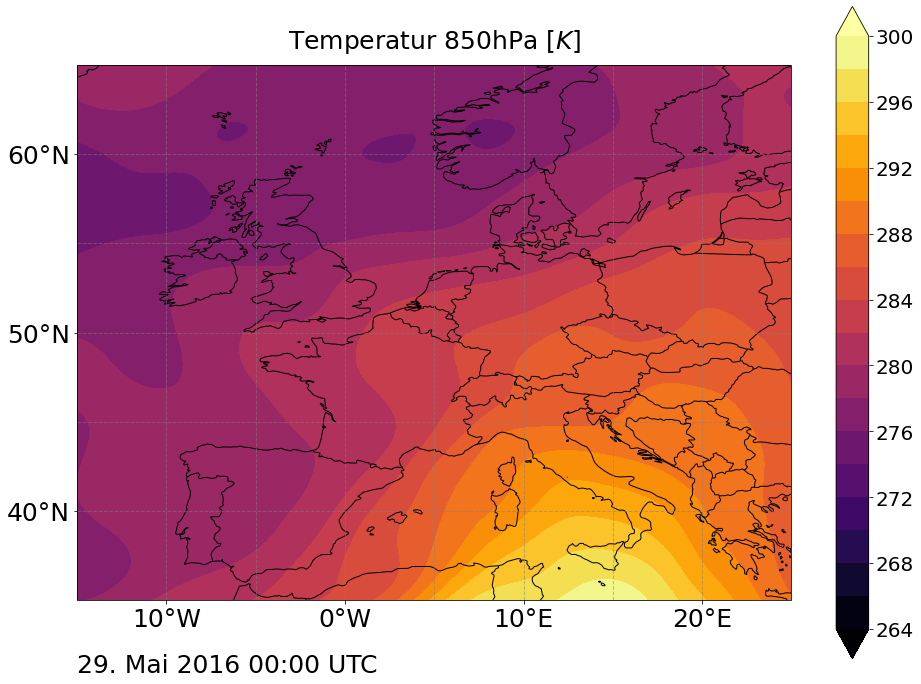

In [19]:
#Color Contourplot

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

cs1 = plt.contourf(lon, lat, datadict_od_t_850[0][timelist[0]], 
                   cmap='inferno', extend='both', levels=np.arange(264,301,2), transform=crs.PlateCarree()) 
cb = plt.colorbar(cs1)
cb.ax.tick_params(labelsize=20)

ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([-15,25,35,65], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[-10,0, 10,20], crs=crs.PlateCarree())
ax.set_yticks(ticks=[40, 50,60], crs=crs.PlateCarree())
ax.set_title('Temperatur 850hPa [$K$]', size = 25,y=1.02)
ax.text(-15,31,day+'. '+m+' 2016 '+t+' UTC', size =25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots/Temperatur_850_2016'+month+day+time+'.png')

### Temperaturdifferenz 850hPa - 500hPa

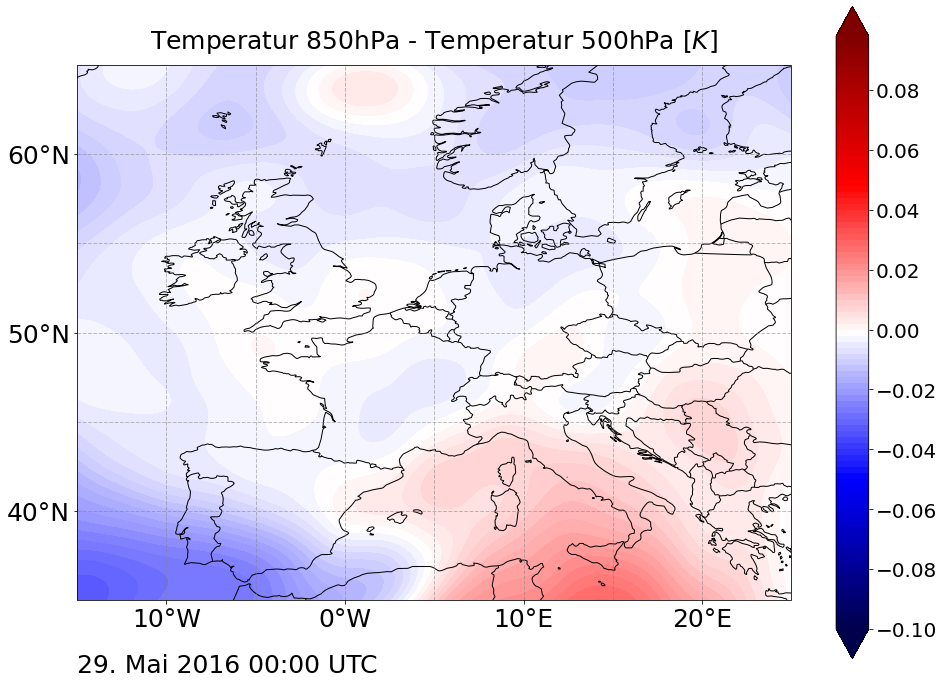

In [20]:
#Color Contourplot

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

cs1 = plt.contourf(lon, lat, (datadict_od_t_850[0][timelist[0]]-datadict_od_t_500[0][timelist[0]])/350-0.0792, 
                   cmap='seismic', extend='both', levels=np.arange(-0.1,0.1,0.002), transform=crs.PlateCarree()) 
cb = plt.colorbar(cs1)
cb.ax.tick_params(labelsize=20)

ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([-15,25,35,65], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[-10,0, 10,20], crs=crs.PlateCarree())
ax.set_yticks(ticks=[40, 50,60], crs=crs.PlateCarree())
ax.set_title('Temperatur 850hPa - Temperatur 500hPa [$K$]', size = 25,y=1.02)
ax.text(-15,31,day+'. '+m+' 2016 '+t+' UTC', size =25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots/Temperatur_850_2016'+month+day+time+'.png')

### Äquivalentpotentielle Temperatur 850hPa

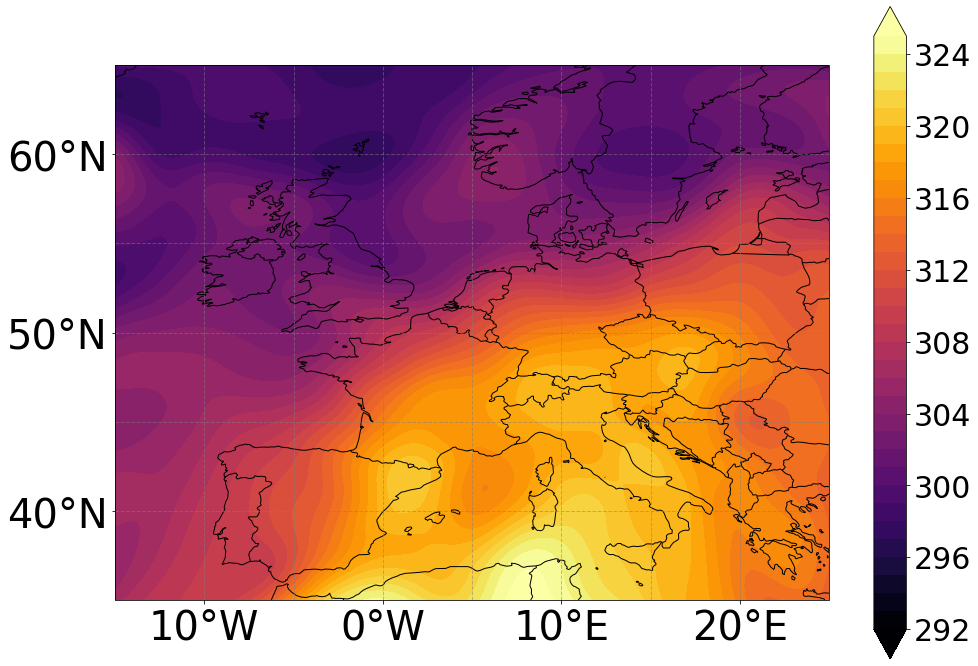

In [12]:
#Color Contourplot

r = np.divide(datadict_od_qv_850[0][timelist[0]],1-datadict_od_qv_850[0][timelist[0]])
Lv = 2.5e6
cp = 1005.7
p = 85000
p0 = 100000
EqiT = np.add(datadict_od_t_850[0][timelist[0]],Lv/cp*r)*(100000/p)**(2/7)

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

cs1 = plt.contourf(lon, lat, EqiT, 
                   cmap='inferno', extend='both', levels=np.arange(292,326,1), transform=crs.PlateCarree()) 
cb = plt.colorbar(cs1)
cb.ax.tick_params(labelsize=30)

ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([-15,25,35,65], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[-10,0, 10,20], crs=crs.PlateCarree())
ax.set_yticks(ticks=[40, 50,60], crs=crs.PlateCarree())
# ax.set_title('Äquivalentpotentielle Temperatur 850hPa [$K$]', size = 25,y=1.02)
# ax.text(-15,31,day+'. '+m+' 2016 '+t+' UTC', size =25)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_ECMWF/new_ÄquiT_850_2016'+month+day+time+'.png')

### Domäne

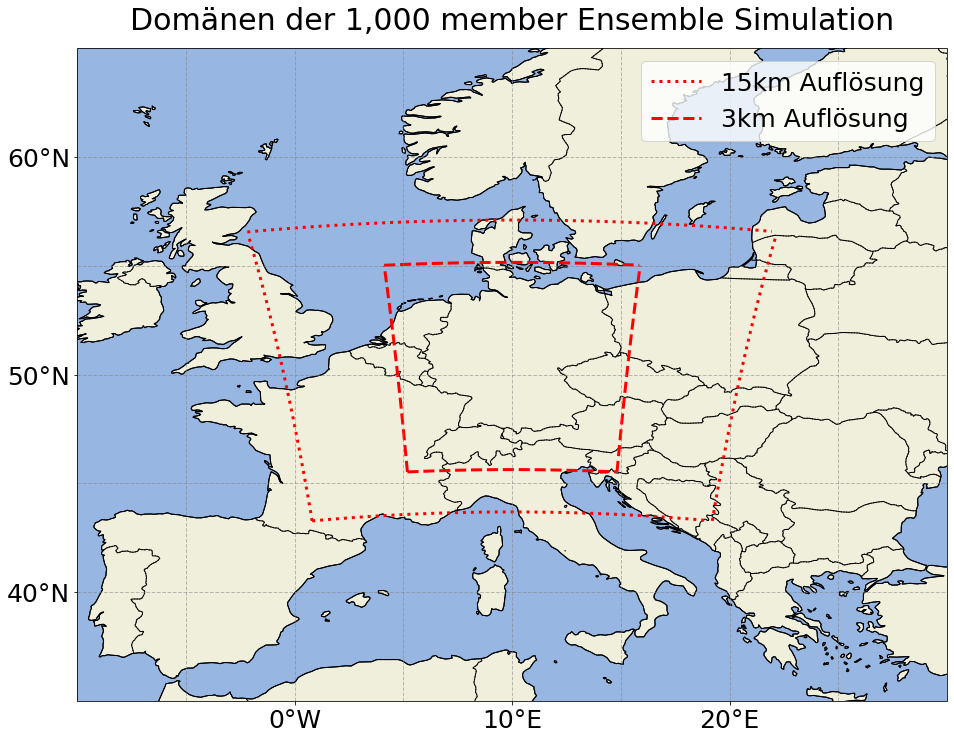

In [127]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

transform=crs.PlateCarree()

linecolor = 'red'
linebold = 3

latlb = 0
latub = d1lat.shape[0] - 1
lonlb = 0
lonub = d1lat.shape[1] - 1
xlalblolb, ylalblolb = d1lon[latlb, lonlb:lonub], d1lat[latlb, lonlb:lonub]
xlaublolb, ylaublolb = d1lon[latub, lonlb:lonub], d1lat[latub, lonlb:lonub]
xlalbloub, ylalbloub = d1lon[latlb:latub, lonlb], d1lat[latlb:latub, lonlb]
xlaubloub, ylaubloub = d1lon[latlb:latub, lonub], d1lat[latlb:latub, lonub]
plt.plot(xlalblolb, ylalblolb, color=linecolor, linewidth=linebold, ls=':', label='15km Auflösung')
plt.plot(xlaublolb, ylaublolb, color=linecolor, linewidth=linebold, ls=':')
plt.plot(xlalbloub, ylalbloub, color=linecolor, linewidth=linebold, ls=':')
plt.plot(xlaubloub, ylaubloub, color=linecolor, linewidth=linebold, ls=':')


latlb = 0
latub = d2lat.shape[0] - 1
lonlb = 0
lonub = d2lat.shape[1] - 1
xlalblolb, ylalblolb = d2lon[latlb, lonlb:lonub], d2lat[latlb, lonlb:lonub]
xlaublolb, ylaublolb = d2lon[latub, lonlb:lonub], d2lat[latub, lonlb:lonub]
xlalbloub, ylalbloub = d2lon[latlb:latub, lonlb], d2lat[latlb:latub, lonlb]
xlaubloub, ylaubloub = d2lon[latlb:latub, lonub], d2lat[latlb:latub, lonub]
plt.plot(xlalblolb, ylalblolb, color=linecolor, linewidth=linebold, ls='--', label='3km Auflösung')
plt.plot(xlaublolb, ylaublolb, color=linecolor, linewidth=linebold, ls='--')
plt.plot(xlalbloub, ylalbloub, color=linecolor, linewidth=linebold, ls='--')
plt.plot(xlaubloub, ylaubloub, color=linecolor, linewidth=linebold, ls='--')


plt.legend(fontsize=25)


ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([-10,30,35,65], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[0, 10, 20], crs=crs.PlateCarree())
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
ax.set_title('Domänen der 1,000 member Ensemble Simulation', size = 30,y=1.02)
ax.set_yticks(ticks=[40, 50, 60], crs=crs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
#ax.add_feature(cfeature.LAKES, alpha=0.5)
#ax.add_feature(cfeature.RIVERS)
